# MASTML

In [23]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
import matplotlib.pyplot as plt
import random
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.models import SklearnModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel
import time

## Load Data

In [24]:
pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

# LOAD DATA
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

# PARSE DATA
x_clean = data[['composition', 'structure', 'space group']]
compositions = x_clean['composition']
# structure = x_clean['structure']
print("num compositions", len(compositions))

num compositions 74992


In [25]:
# subset n random values
comp_zip_y = list(zip(compositions, data_y.T.values.tolist()[0]))

## Functions

In [48]:

def create_subset(sample_from, n=1000):
    """Creates subset of size `n`"""
    subset_compositions, subset_y = zip(*random.sample(sample_from, n))
    subset_x = pd.DataFrame(subset_compositions)
    return subset_x, subset_y


def vectorize(x_compositions, y):
    """Computes elemental features and applies normalization"""
    e_features = ElementalFeatureGenerator(x_compositions)
    e_features.fit()

    feat_x, feat_y = e_features.transform()

    x = feat_x

    # Scale
    preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
    x = preprocessor.evaluate(X=x, y=y)

    return x, y


def compute_elemetal_fractions(x_compositions):
    """Computes elemental fractions"""
    e_fraction = ElementalFractionGenerator(x_compositions)
    e_fraction.fit()
    frac_x, frac_y = e_fraction.transform()  # only used to create domains later
    return frac_x, frac_y


def featurize(x, y, n=25):
    """With random forest choses top `n` features"""
    model = SklearnModel(model='RandomForestRegressor')
    selector = EnsembleModelFeatureSelector(model=model, n_features_to_select=n)
    x = selector.evaluate(X=x, y=y)
    return x


def rmse(predictions, targets):
    """Root mean square error"""
    return np.sqrt(((predictions - targets) ** 2).mean())


def showScores(x, y, y_, gpr, std):
    """Show evaluation metrics given `x`, `y`, and predicted y, `y_` and GPR model `gpr`"""

    r2_score = gpr.score(x, y)
    print(f"R^2 score: {r2_score}")
    print(f"rmse", rmse(y, y_))
    err = rmse(y, y_) / np.std(y)
    print(f"R^2 score / std: {err}")
    print(f"Uncertainty mean: {np.mean(std)} std: {np.std(std)}")

    # performance graph
    max_val = max(max(y), max(y_))
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    ax.set_xlim((0, max_val))
    ax.set_ylim((0, max_val))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()

    # uncertainty graph
    plt.hist(std)
    plt.show()


def fit_gpr(x, y):
    """Given `x` and `y` returns a trained GPR model"""

    gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)

    print("Start fitting")
    stime = time.time()

    gpr.fit(x, y)

    print("Done. Time for GPR fitting: %.3f" % (time.time() - stime))
    return gpr


## One Run

In [27]:
# # Subset
# subset_x, subset_y = create_subset(comp_zip_y, n=1000)
# # Vectorize
# x, y = vectorize(subset_x, subset_y)
# # Featurize
# x = featurize(x)
# # Fit GPR
# gpr = fit_gpr(x, y)
# # Predict
# y_, std_ = gpr.predict(x, return_std=True)
# # Score
# # showScores(x, y, y_, gpr, std_)

In [28]:
# # Compute domain assesment
# # Split x and y by domains using frac_x
# frac_x, _ = compute_elemetal_fractions(subset_x)

# element = "O"
# threshold = 0
# subset_y_df = pd.DataFrame(subset_y)
# g1 = frac_x[frac_x[element] <= threshold]
# g1_y = subset_y_df[frac_x[element] <= threshold]
# g2 = frac_x[frac_x[element] > threshold]
# g2_y = subset_y_df[frac_x[element] > threshold]

## Run to test domains

In [29]:
# # create subsets such that there is enough training (at least 500)
# subset_x = subset_y = frac_x = None
# n = 2000
# element = "O"
# threshold = 0
# min_train_group = 500

# for i in range(1000):
#     # create subset
#     subset_x, subset_y = create_subset(comp_zip_y, n=n)
#     # from subset create domains
#     frac_x, _ = compute_elemetal_fractions(subset_x)
#     g1_ = frac_x[frac_x[element] <= threshold]

#     if len(g1_) >= min_train_group:
#         break
#     n *= 1.1
#     n = int(n)

# # Vectorize
# x, y = vectorize(subset_x, subset_y)

# # Featurize
# x = featurize(x)

In [30]:
# # create groups
# subset_y_df = pd.DataFrame(subset_y)
# g1 = x[frac_x[element] <= threshold]
# g1_y = subset_y_df[frac_x[element] <= threshold]
# g2 = x[frac_x[element] > threshold]
# g2_y = subset_y_df[frac_x[element] > threshold]

# # train GPR on in-domain
# gpr_domain = fit_gpr(g1, g1_y)

# # test on in-domain, out-domain, all
# y_in, std_in = gpr_domain.predict(g1, return_std=True) # in-domain
# y_out, std_out = gpr_domain.predict(g2, return_std=True) # out-domain
# y_all, std_all = gpr_domain.predict(x, return_std=True) # all

In [31]:
# in-domain
# showScores(g1, g1_y, y_in, gpr_domain, std_in)
# out-domain
# showScores(g2, g2_y, y_out, gpr_domain, std_out)
# all
# showScores(x, y, y_all, gpr_domain, std_all)

## Test physical groups

In [49]:
def test_domain(comp_zip_y, n = 2000, element = "O", threshold = 0, min_train_group = 500): # ! change element default to array
    """Runs all steps: subset, vectorize, fit, test. Then test in-domain, out-domain, and all for a subset of the data given in the list of tuples `comp_zip_y` which is (composition, y-value)"""
    # create subsets such that there is enough training (at least min_train_group)
    subset_x = subset_y = frac_x = None

    for i in range(1000):
        # create subset
        subset_x, subset_y = create_subset(comp_zip_y, n=n)
        # from subset create domains
        frac_x, _ = compute_elemetal_fractions(subset_x)
        g1_ = frac_x[frac_x[element] <= threshold] # ! change to use array

        if len(g1_) >= min_train_group:
            break
        n *= 1.1
        n = int(n)

    # Vectorize
    x, y = vectorize(subset_x, subset_y)

    # Featurize
    x = featurize(x, y)

    # create groups
    subset_y_df = pd.DataFrame(subset_y)
    g1_x = x[frac_x[element] <= threshold] # ! change to use array
    g1_y = subset_y_df[frac_x[element] <= threshold] # ! change to use array
    g2_x = x[frac_x[element] > threshold] # ! change to use array
    g2_y = subset_y_df[frac_x[element] > threshold] # ! change to use array

    # train GPR on in-domain
    gpr_domain = fit_gpr(g1_x, g1_y)

    # test on in-domain, out-domain, all
    y_in, std_in = gpr_domain.predict(g1_x, return_std=True) # in-domain
    y_out, std_out = gpr_domain.predict(g2_x, return_std=True) # out-domain
    y_all, std_all = gpr_domain.predict(x, return_std=True) # all

    # in-domain
    print("in-domain")
    showScores(g1_x, g1_y, y_in, gpr_domain, std_in)
    # out-domain
    print("out-domain")
    showScores(g2_x, g2_y, y_out, gpr_domain, std_out)
    # all
    print("all")
    showScores(x, y, y_all, gpr_domain, std_all)

Comparison of performance for `n = 2000` and `n = 1000` shows that n needs to be large enough to get resulting difference in uncertainties.

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 59.464


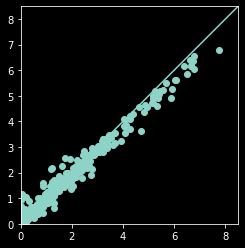

R^2 score: 0.9809938865083286
rmse 0    0.17727
dtype: float64
R^2 score / std: 0    0.137863
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


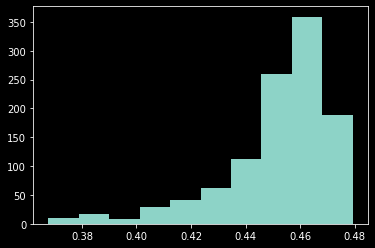

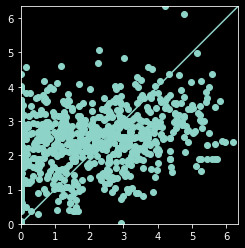

R^2 score: -0.13872557059753232
rmse 0    1.733811
dtype: float64
R^2 score / std: 0    1.067111
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


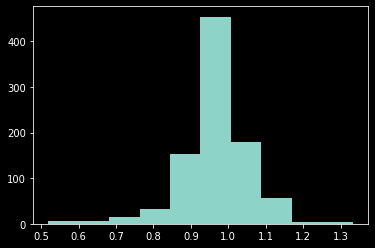

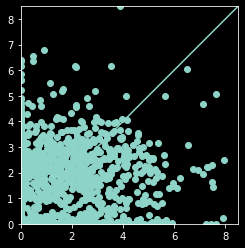

R^2 score: -0.7496754976445383
rmse 2.127490770363343
R^2 score / std: 1.3339213658127669
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


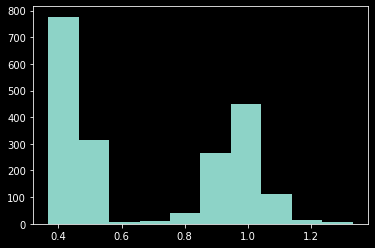

In [33]:
test_domain(comp_zip_y, n = 2000, element = "O", threshold = 0, min_train_group = 500)

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 11.612
in-domain


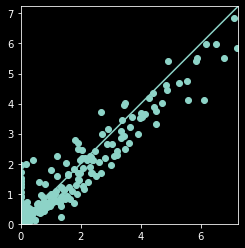

R^2 score: 0.9175245708724186
rmse 0    0.389047
dtype: float64
R^2 score / std: 0    0.287185
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


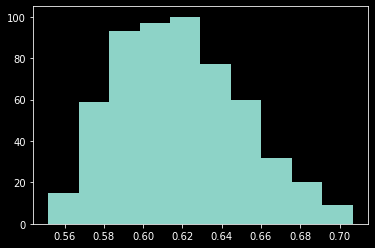

out-domain


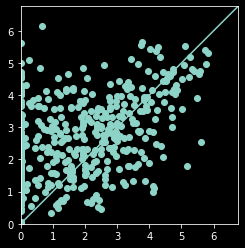

R^2 score: -0.2140979791882538
rmse 0    1.802097
dtype: float64
R^2 score / std: 0    1.101861
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


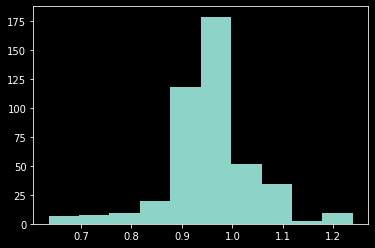

all


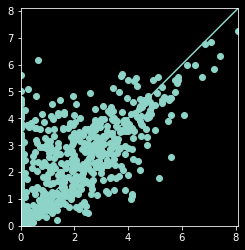

R^2 score: 0.41481305456228945
rmse 2.314206738320401
R^2 score / std: 1.4418567123563657
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


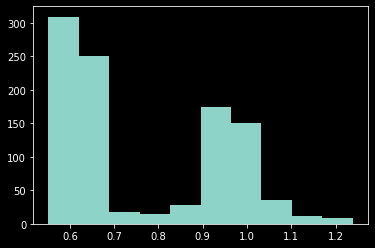

In [45]:
test_domain(comp_zip_y, n = 1000, element = "O", threshold = 0, min_train_group = 500)

Initial test of groupings.

O
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 74.486
in-domain
R^2 score: 0.7150484104636201
rmse 0    0.707476
dtype: float64
R^2 score / std: 0    0.533809
dtype: float64
Uncertainty mean: 0.8041089884471198 std: 0.027035730459712984


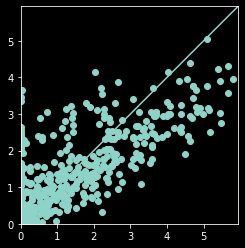

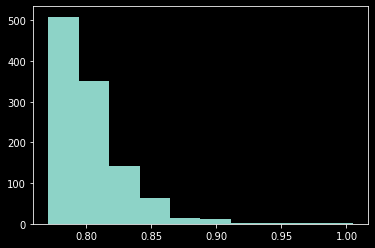

out-domain
R^2 score: 0.043683667823092964
rmse 0    1.53572
dtype: float64
R^2 score / std: 0    0.977914
dtype: float64
Uncertainty mean: 0.8642625808075864 std: 0.028629714619175548


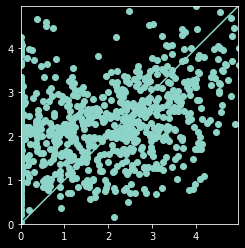

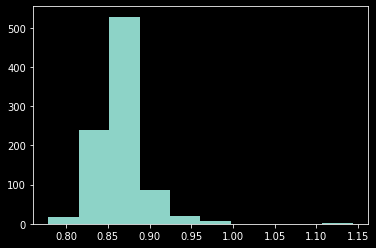

all
R^2 score: 0.4341795764570886
rmse 2.009734407614853
R^2 score / std: 1.3080699706377932
Uncertainty mean: 0.8311480282131495 std: 0.04081911914734324


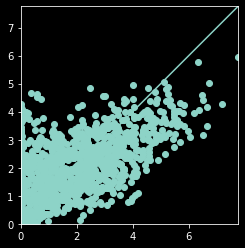

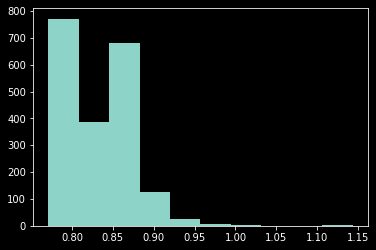

B
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 226.660
in-domain
R^2 score: 0.6551078577133478
rmse 0    0.888756
dtype: float64
R^2 score / std: 0    0.587275
dtype: float64
Uncertainty mean: 1.034160254959876 std: 0.040506331645199144


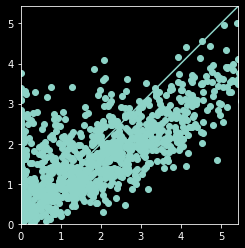

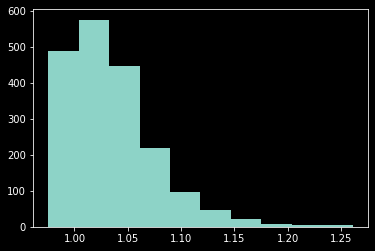

out-domain
R^2 score: 0.5988715204724264
rmse 0    1.419495
dtype: float64
R^2 score / std: 0    0.633347
dtype: float64
Uncertainty mean: 1.1397016564629001 std: 0.10820492171424292


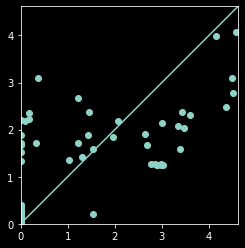

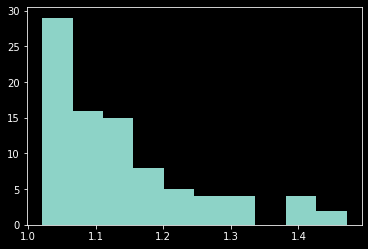

all
R^2 score: 0.6540189593458261
rmse 1.9209475801136056
R^2 score / std: 1.2305011369675773
Uncertainty mean: 1.0387513059252578 std: 0.050419928524990144


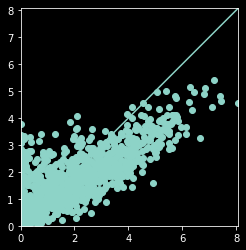

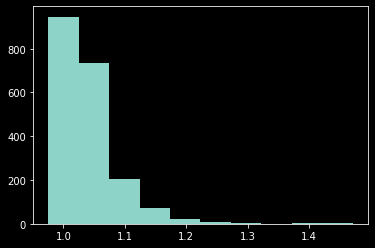

F
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 175.958
in-domain
R^2 score: 0.7002000519672991
rmse 0    0.820796
dtype: float64
R^2 score / std: 0    0.54754
dtype: float64
Uncertainty mean: 0.9732695062908303 std: 0.03652776787118876


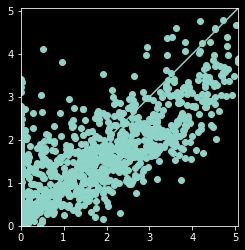

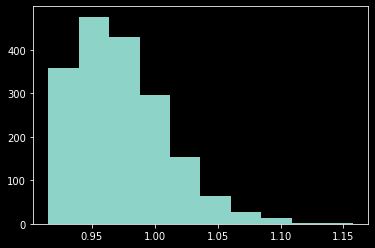

out-domain
R^2 score: -0.06342410428816825
rmse 0    2.192322
dtype: float64
R^2 score / std: 0    1.031225
dtype: float64
Uncertainty mean: 1.1988568718651074 std: 0.07042281679859468


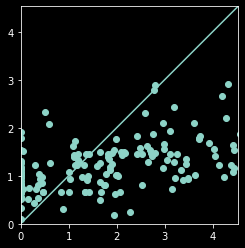

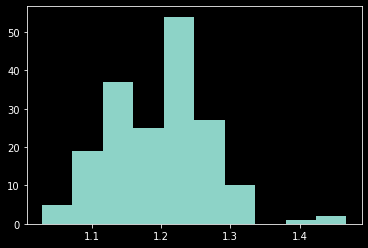

all
R^2 score: 0.6043578041998751
rmse 1.976592783745066
R^2 score / std: 1.2158447356234507
Uncertainty mean: 0.9935723691925152 std: 0.07634395533551684


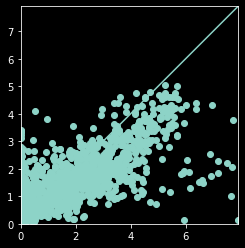

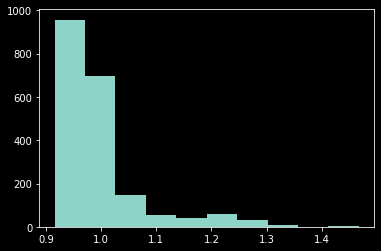

Cl
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 243.165
in-domain
R^2 score: 0.6691516460089784
rmse 0    0.909175
dtype: float64
R^2 score / std: 0    0.575194
dtype: float64
Uncertainty mean: 1.0738468987975074 std: 0.0407485552877874


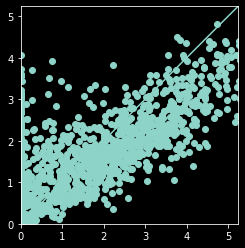

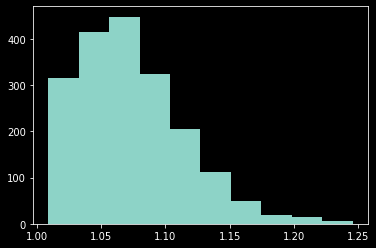

out-domain
R^2 score: 0.19703213574078915
rmse 0    1.657186
dtype: float64
R^2 score / std: 0    0.896085
dtype: float64
Uncertainty mean: 1.18643504973356 std: 0.09326688018829556


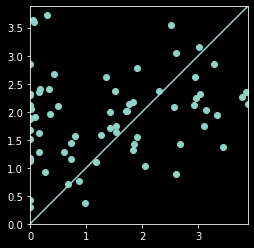

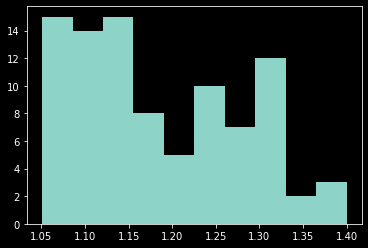

all
R^2 score: 0.6463802064848106
rmse 1.9867230476418047
R^2 score / std: 1.2357931853764015
Uncertainty mean: 1.078969659665098 std: 0.05031108589751024


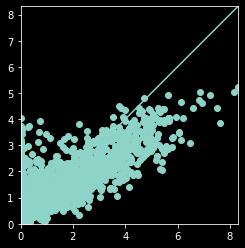

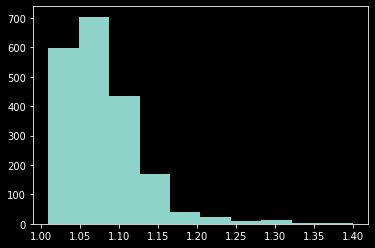

Br
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 198.563
in-domain
R^2 score: 0.6940170265713665
rmse 0    0.892692
dtype: float64
R^2 score / std: 0    0.553157
dtype: float64
Uncertainty mean: 1.0457432533546533 std: 0.04020717410673135


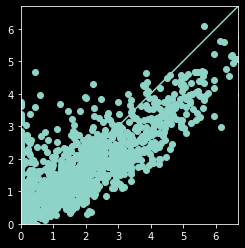

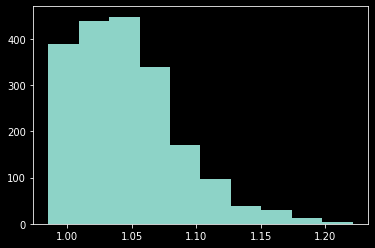

out-domain
R^2 score: 0.3635327951065136
rmse 0    1.304666
dtype: float64
R^2 score / std: 0    0.797789
dtype: float64
Uncertainty mean: 1.1726449277929931 std: 0.0750756470585061


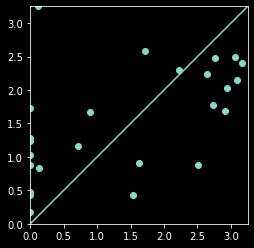

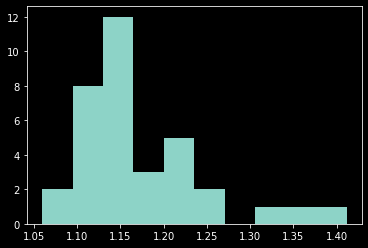

all
R^2 score: 0.6899953752130805
rmse 2.0313171795054714
R^2 score / std: 1.2545440517594886
Uncertainty mean: 1.047964032657324 std: 0.04431535828364547


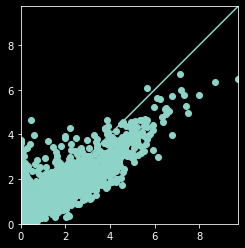

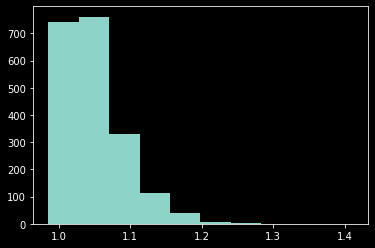

I
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 254.740
in-domain
R^2 score: 0.642416741018325
rmse 0    0.959882
dtype: float64
R^2 score / std: 0    0.597983
dtype: float64
Uncertainty mean: 1.076300336271758 std: 0.034322337695992904


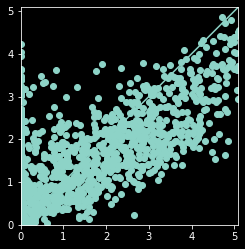

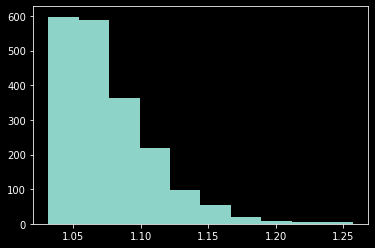

out-domain
R^2 score: 0.19432252590110544
rmse 0    1.090136
dtype: float64
R^2 score / std: 0    0.897595
dtype: float64
Uncertainty mean: 1.2047120033871903 std: 0.04673255327038273


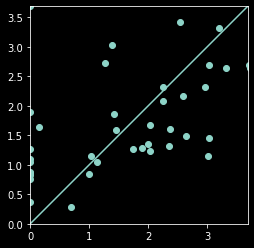

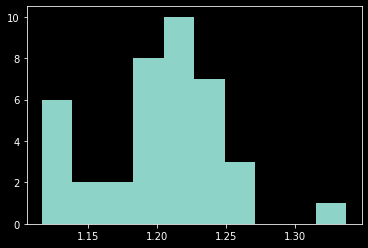

all
R^2 score: 0.6379016428768849
rmse 1.9932861693579575
R^2 score / std: 1.246066685967225
Uncertainty mean: 1.078804363780509 std: 0.03889619874903852


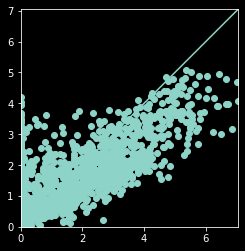

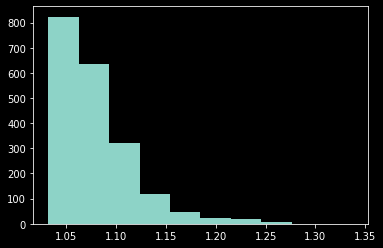

In [51]:

# !!!Warning!!! This will take about 40 minutes to run
material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
for element in material_group_char:
    print("="*10)
    print(element)
    test_domain(comp_zip_y, n = 2000, element = element, threshold = 0, min_train_group = 500)
    print("="*10)

Setup ptable groupings

In [52]:
def str_to_arr(s: str) -> list:
    """Takes in a string list (delim by ',') and returns string array"""
    x = [x.strip() for x in s.split(",")]
    return x

# Alkali metals
alkali_metals = "Li, Na, K, Rb, Cs, Fr"
alkali_metals = str_to_arr(alkali_metals)
# Alkaline earth metals
alkali_earth_metals = "Be, Mg, Ca, Sr, Ba, Ra"
alkali_earth_metals = str_to_arr(alkali_earth_metals)
# Lanthanoids
lanthanoids = "La, Ce, Pr, Nd, Pm, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu"
lanthanoids = str_to_arr(lanthanoids)
# Transition Metals
transition_metals = "Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Rf, Db, Sg, Bh, Hs"
transition_metals = str_to_arr(transition_metals)
# Post-transition metals
post_transition_metals = "Al, Ga, In, Sn, Tl, Pb, Bi, Po"
post_transition_metals = str_to_arr(post_transition_metals)
# Metaloids
metaloids = "B, Si, Ge, As, Sb, Te, At"
metaloids = str_to_arr(metaloids)
# Reactive nonmetals
reactive_nonmetals = "H, C, N, O, F, P, S, Cl, Se, Br, I"
reactive_nonmetals = str_to_arr(reactive_nonmetals)

ptable_groups = [alkali_metals, alkali_earth_metals, lanthanoids, transition_metals, post_transition_metals, metaloids, reactive_nonmetals]

# Leave these elements out of groups because they are chemically distinct
chem_distinct = ["O", "B", "F", "Cl", "Br", "I"]

for i, g in enumerate(ptable_groups):
    ptable_groups[i] = [e for e in g if e not in chem_distinct]

print(*ptable_groups, sep="\n")

['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr']
['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra']
['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Rf', 'Db', 'Sg', 'Bh', 'Hs']
['Al', 'Ga', 'In', 'Sn', 'Tl', 'Pb', 'Bi', 'Po']
['Si', 'Ge', 'As', 'Sb', 'Te', 'At']
['H', 'C', 'N', 'P', 'S', 'Se']


In [ ]:

# TODO: Add functionality to handle arrays of elements to test_domain so I can do more advanced groupings
# TODO: Run on all groupings

for group in ptable_groups:
    print("="*10)
    print(f"group: {group}")
    test_domain(comp_zip_y, n = 2000, element = group, threshold = 0, min_train_group = 500)
    print("="*10)

## OLD CODE

In [47]:
# list(x.items())
# print(*x.items(), sep="\n")
# print(x.iloc[0])

## verify rows sum to 1
# total = x.sum(axis=1, numeric_only= True)
# print("total", total)

# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
thresholds = [0]
for mat in material_group_char:
    continue
    print("Grouping for", mat)
    st1 = 100
    st2 = 10

    for th in thresholds:
        # Make split
        group_X = x[x[mat] > th]
        not_group_X = x[x[mat] <= th]
        # group_y = [None for x in group_X]
        # not_group_y = [None for x in not_group_y]
        group_y = y[x[mat] > th]
        not_group_y = y[x[mat] <= th]

        perc_in_group = group_X.shape[0]/x.shape[0]
        print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
        # if the split leaves an empty group skip
        if perc_in_group == 0:
            continue

        # group_X.iloc(100)
        group_X = np.array(group_X)
        group_y = np.array(group_y)

        group_X = group_X[0:1000,:]
        group_y = group_y[0:1000,:]
        
        # do GPR stuff
        print(f"Doing GPR for {mat}")
        # gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) 
        gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
        print("gpr:", gpr)
        # break
        stime = time.time()
        print("Start fitting")
        # gpr.fit(group_X, group_y)
        print("Time for GPR fitting: %.3f" % (time.time() - stime))
        print("Done")

        x_, std_ = gpr.predict(group_X, return_std=True)
        print("x_", x_)
        print("std_", std_)

        # Predict using gaussian process regressor
        # stime = time.time()
        # y_gpr = gpr.predict(X_plot, return_std=False)
        # print("Time for GPR prediction: %.3f" % (time.time() - stime))

# gpr.kernel_
# np.std(group_X)